# Import & function

In [64]:
from PIL import Image, ImageDraw, ImageOps
from PIL.PngImagePlugin import PngInfo
import cv2 # separate conda env for opencv
# if you cant change kernel to `cv`, ctrl+shift+p -> python: select interpreter -> select in folder:  C:\Users\ll357\AppData\Local\anaconda3\envs\cv\python.exe -> now you can select cv kernel

import os
from os import listdir
from os.path import isfile, join
import glob
from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# stim size in pixels

In [24]:
## trigonometry for vis stim size: convert visual angle to pixels

visual_angle = 30
d_cm = 26.67 # distance from eye to monitor
w_cm = 53.34 # width of monitor
w_pix = 1920
h_cm = 29.972 # height of monitor, screen area only
h_pix = 1080

theta = visual_angle / 2 / 180 * np.pi # half of the visual angle, converted to radians
r_cm = d_cm * np.tan(theta) # radius of visual stim on screen
r_pix = r_cm * w_pix / w_cm
r_pix2 = r_cm * h_pix / h_cm
assert np.floor(r_pix) == np.floor(r_pix2) # two estimation should be close

stim_diameter = int(r_pix + r_pix2) # diameter of visual stim on screen, int takes care of np.floor
stim_diameter

514

In [25]:
## OR use stim size in pixel from literature: https://www.biorxiv.org/content/10.1101/2023.11.03.565500v1.full

stim_height = 135
stim_width = int(stim_height / h_cm * w_cm)
stim_width, stim_height

(240, 135)

# Construct Gaussian mask (depre)

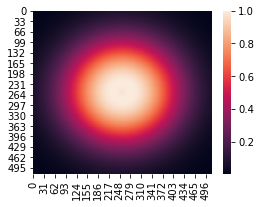

In [3]:
'''
https://mworks.tenderapp.com/discussions/questions/1296
https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue
https://mworks.tenderapp.com/discussions/questions/736#comment_43095821
https://mworks.github.io/documentation/0.8/components/drifting_grating_stimulus.html
https://mworks.tenderapp.com/search?utf8=%E2%9C%93&q=mask+std_dev+&t=d&recommend=1

Gaussian mask is computed on a 2x2 square, centered at the origin
dist is distance from the center
The mask is then stretched to cover a rectangle of x_size by y_size degrees. 
If the x and y sizes are equal, then the mask is scaled by size/2 in both directions, so std_dev has units of size/2 degrees

central region of the mask can have values greater than one 
(see https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue). 
However, the mask value is used as the output color's alpha, which is clamped to the range [0,1]. 
Hence, every pixel in the central region gets an alpha of 1.
'''

# mean=0.1 & std=0.3 for static grating data we recorded in 2020
# mask_mean = 0.1 # used for SF5
# mask_mean = 0.225 # used for bunny500 & bunnytop data, also use for interweaved grat nat noise
mask_mean = 0.1 # try this to get rid of the center "black circle"
# mask_std = 0.3 # std_dev in mwork
mask_std = 0.3985 # try this to get rid of the center "black circle" -> ensure peak of gaussian is 1, not above 1 which creates black circle

u = np.linspace(-1, 1, stim_diameter, endpoint=True) # nstep = grating_diameter in terms of pixel number
[x, y] = np.meshgrid(u, u)
y = y[::-1] # ensure y axis points upwards

distance = np.sqrt(x**2 + y**2)
mask = np.exp(-1/2 * ((distance-mask_mean) / mask_std)**2) / (mask_std * np.sqrt(2*np.pi)) # default drifting grating has normalization term
mask_flat_peak = mask.copy()
mask_flat_peak[mask_flat_peak>1.0] = 1.0 # alpha value is capped at 1, creating flat peak

mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:]))
mask_0_base[mask_0_base<0] = 0 # force edge(outside of incircle)=0

# mask_step = mask_flat_peak.copy()
# mask_step[mask_step<1] = np.nan # mask as nan->1 step function to keep only the center, for "ensure not blank"
# mask_0_255 = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 
# mask_0_255[mask_0_255<0] = 0 # convert mask from 0-1 to 0-255, and force edge(outside of incircle)=0
# mask_nan_base = (mask_flat_peak - max(mask_flat_peak[0,:])) 
# mask_nan_base[mask_nan_base<0] = np.nan

plt.figure(figsize=(4,3))
sns.heatmap(mask_flat_peak, annot=False, fmt=".1g", cbar=True);

(1.0, 1.0011098261124147)

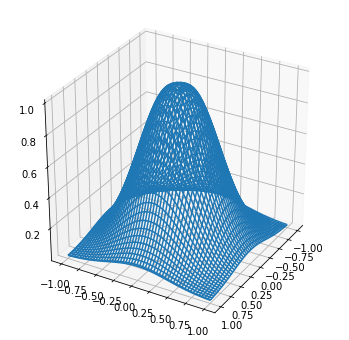

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x,y,mask_flat_peak, rstride=10, cstride=10)
ax.view_init(elev=30, azim=30)

np.amax(mask_flat_peak), np.amax(mask)

# Grayscale & cut to chunks
option to apply Gaussian mask as alpha, but currently we use alpha mask from mworks

In [26]:
def save_chunk(i, j, chunk_width, chunk_height, im, save_path, input_img, k, verbose=False, save=False):
    box = (j, i, j+chunk_width, i+chunk_height)
    chunk = im.crop(box) # cut into square piece
    chunk_arr = np.array(chunk)
    img_no_mask = Image.fromarray(chunk_arr)

    if verbose: 
        display(img_no_mask)
        
    if save:
        input_img_filename = os.path.basename(input_img)
        img_no_mask.save(os.path.join(save_path, input_img_filename + "_" + str(k) + "_no_mask.png"))


def prep_img(input_path, input_img, chunk_height, chunk_width, save_path, verbose=False, save=False):

    input_full = os.path.join(input_path, input_img)    
    im = Image.open(input_full).convert('L') # convert to grayscale
    img_width, img_height = im.size
    
    k = 0
    for i in range(0, img_height-chunk_height, chunk_height):
        for j in range(0, img_width-chunk_width, chunk_width):
            save_chunk(i, j, chunk_width, chunk_height, im, save_path, input_img, k, verbose=verbose, save=save)

            ## if apply gaussian mask in preprossing
            # rgba = cv2.cvtColor(chunk_arr, cv2.COLOR_RGB2RGBA) # create img w alpha channel
            # mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 
            # mask_0_base[mask_0_base<0] = 0 # convert mask from 0-1 to 0-255, and force edge(outside of incircle)=0
            # rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
            # img = Image.fromarray(rgba)
            # img.save(save_path + input_img[:-4] + "_" + str(k) + ".png")
            
            k = k+1
            if k > 3: break
    im.close() # must close image to release memory

In [50]:
input_path = r'C:\Users\ll357\Downloads\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\train'.replace("\\", "/") # NOTE: imagenet data came from https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data
save_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Mwork\stimulus_image\imagenet\full_screen_cut/'.replace('\\', '/')
subdir_list = [f for f in listdir(input_path)]

i = 0
for subdir in tqdm(subdir_list):
    np.random.seed(i) # set random seed to choose a file from subdir
    file_list = [f for f in listdir(input_path + '/' + subdir) if isfile(join(input_path + '/' + subdir, f))]
    rand_file = np.random.choice(file_list)
    input_img = os.path.join(input_path, subdir, rand_file)

    chunk_height = stim_height
    chunk_width = stim_width
    prep_img(input_path, input_img, chunk_height, chunk_width, save_path, verbose=False, save=True)
    i += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

# ensure not blank

In [65]:
def discard_img(input_path, input_img, save_path_keep, save_path_discard):

    input_full = os.path.join(input_path, input_img)
    img = Image.open(input_full)
    im_arr = np.array(img) # im_arr.shape should be stim_height x stim_width

    ## take only center of image, ensure center is not blank
    center_height = int(im_arr.shape[0]/2)
    center_width = int(im_arr.shape[1]/2)
    im_center = im_arr[center_height-stim_height:center_height+stim_height, center_width-stim_width:center_width+stim_width]
    im_arr = im_center.copy()

    ## criterion minmax: from top to bottom percentile, intensity covers > x% of 0-255 full range
    im_arr_notnan = im_arr[~np.isnan(im_arr)]
    npixel = 100
    minmax_thresh = 0.564 # determined below by distribution of minmax
    minmax = (np.mean(np.sort(im_arr_notnan)[::-1][:npixel]) 
            - np.mean(np.sort(im_arr_notnan)[:npixel])) / 256
    flag_minmax = minmax >= minmax_thresh
    
    ## criterion edge: can detect edge in the un-blurred center
    # mask_step_0 = mask_step.copy()
    # mask_step_0[np.isnan(mask_step_0)] = 0
    edges = cv2.Canny(im_arr, threshold1=50, threshold2=100) # remove noises by assuming edges are long lines.
    flag_edge = np.max(edges) > 0
    # flag_edge = np.max(edges*mask_step_0)>0
    
    ## check if img meet BOTH criteria
    if flag_minmax and flag_edge: # if there is enough range of pixel intensity, or edge: keep it
        img.save(os.path.join(save_path_keep, input_img))
    else:
        img.save(os.path.join(save_path_discard, input_img))

    img.close()
    return minmax, np.max(edges)


def clear_dir(target_folder):
    files = glob.glob(os.path.join(target_folder, '*'))
    for f in tqdm(files):
        try:
            os.remove(f)
        except: # TODO: solve "[WinError 32] The process cannot access the file because it is being used by another process:"
            print('cannot remove file', f)

In [66]:
## discard blank img in dir

# tmp = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Mwork\stimulus_image\imagenet/'.replace('\\', '/')
# input_path = os.path.join(tmp, 'full_screen_cut')
# save_path_keep = os.path.join(tmp, 'full_screen_keep')
# save_path_discard = os.path.join(tmp, 'full_screen_discard')

clear_dir(save_path_keep)
clear_dir(save_path_discard)
# file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

minmax_arr = [] # to determine threshold for minmax
edges_max_arr = []
for onefile in tqdm(file_list):
    if onefile.endswith('.png'):
        input_img = onefile
        minmax, edges_max = discard_img(input_path, input_img, save_path_keep, save_path_discard)
        minmax_arr.append(minmax)
        edges_max_arr.append(edges_max)
minmax_arr = np.array(minmax_arr)
edges_max_arr = np.array(edges_max_arr)

  0%|          | 0/2499 [00:00<?, ?it/s]

cannot remove file //duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Mwork/stimulus_image/imagenet/full_screen_keep\n03982430_34696.JPEG_0_no_mask.png


  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/3566 [00:00<?, ?it/s]

## determine blank threshold

(2500,
 array([0.99609375, 0.99609375, 0.99609375, ..., 0.56492188, 0.56488281,
        0.56476563]))

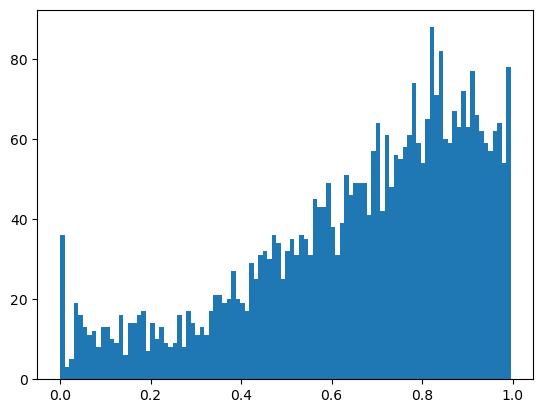

In [61]:
plt.hist(minmax_arr, bins=100);
np.sort(minmax_arr)[::-1][:2500].__len__(), np.sort(minmax_arr)[::-1][:2500]

255

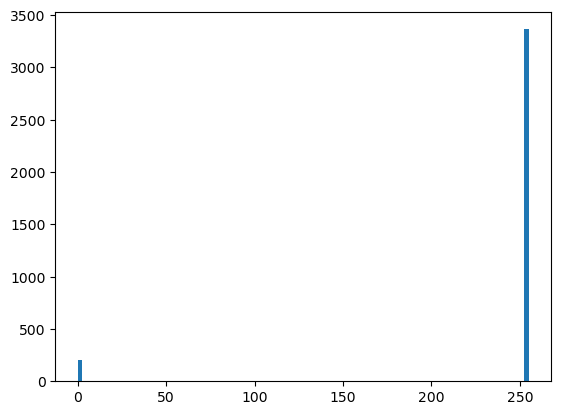

In [59]:
plt.hist(edges_max_arr, bins=100);
np.sort(edges_max_arr)[::-1][2500]

# batch rename for mworks
to 1,2,3...2500

In [68]:
## rename image files in directory to 1,2,3...2500

tmp = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Mwork\stimulus_image\imagenet/'.replace('\\', '/')
input_path = os.path.join(tmp, 'full_screen_keep_renamed')
file_list = [f for f in listdir(input_path) if f.endswith('.png')]

rename_dict = {}
filename_int = 1

for onefile in tqdm(file_list): # 42 s
    old_name = os.path.join(input_path, onefile)
    new_name = os.path.join(input_path, str(filename_int) + '.png')
    rename_dict[filename_int] = onefile # key = new name, value = old name

    os.rename(old_name, new_name)
    filename_int += 1

,0
1,n01644900_2394.JPEG_4_no_mask.png
2,n02165105_9370.JPEG_0_no_mask.png
3,n03110669_54437.JPEG_1_no_mask.png
4,n03929660_5468.JPEG_0_no_mask.png
5,n04347754_57040.JPEG_2_no_mask.png
...,...
2496,n03903868_16079.JPEG_6_no_mask.png
2497,n01882714_27824.JPEG_2_no_mask.png
2498,n04238763_12375.JPEG_0_no_mask.png
2499,n02403003_3736.JPEG_0_no_mask.png


In [73]:
## save old_new_name_dict to csv
df_name = pd.DataFrame.from_dict(rename_dict, orient='index', columns=['old_name']
                                 ).reset_index().rename(columns={'index':'new_name'})
df_name.to_csv(os.path.join(tmp, 'full_screen_keep_renamed', 'rename_dict.csv'), index=False)
df_name

,new_name,old_name
0,1,n01644900_2394.JPEG_4_no_mask.png
1,2,n02165105_9370.JPEG_0_no_mask.png
2,3,n03110669_54437.JPEG_1_no_mask.png
3,4,n03929660_5468.JPEG_0_no_mask.png
4,5,n04347754_57040.JPEG_2_no_mask.png
...,...,...
2495,2496,n03903868_16079.JPEG_6_no_mask.png
2496,2497,n01882714_27824.JPEG_2_no_mask.png
2497,2498,n04238763_12375.JPEG_0_no_mask.png
2498,2499,n02403003_3736.JPEG_0_no_mask.png


## natural img stats
for each image (after multiplying gaussian mask), or for image population:  
lum dist, global contrast, spatial corr, orientation content, spatial freq content

### lum dist

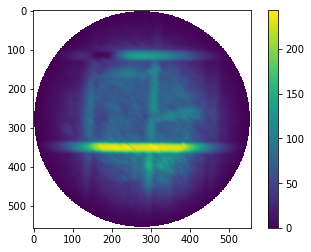

In [253]:
img = Image.open('C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep/0_0.png')
im_arr = np.array(img)
im_nan = im_arr[:,:,0] * mask_nan_base

plt.imshow(im_nan); plt.colorbar()

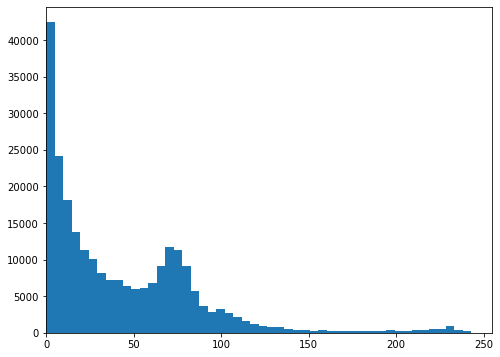

In [254]:
plt.figure(figsize=(8,6))
plt.xlim(0,255);
# plt.hist(im_arr.flatten(), 50);
plt.hist(im_nan.flatten(), 50);

In [243]:
def lum_dist(input_path):

    if input_path[-1] != "/": input_path = input_path + "/"
    file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

    im_mat = np.zeros((len(file_list), grating_diameter**2))
    for i in np.arange(len(file_list)):
        input_img = file_list[i]
        input_full = input_path + input_img
        img = Image.open(input_full)
        
        im_arr = np.array(img)
        im_circle = (im_arr[:,:,0] * mask_nan_base).flatten() # keep the masked incircle of square img chunk
        im_mat[i,:] = im_circle # concat imgs into matrix
        
    return im_mat

In [244]:
im_mat = lum_dist('C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep_500/')
im_mat.shape

(500, 310249)

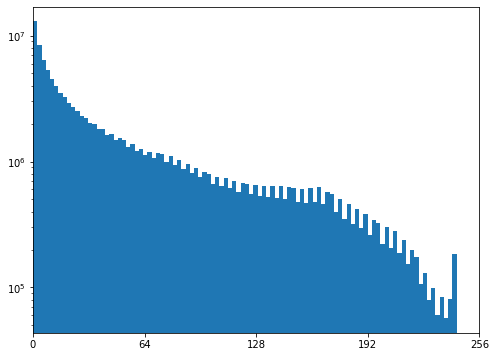

In [252]:
plt.figure(figsize=(8,6))
# plt.hist(im_mat.flatten(), 100);
counts, bins, bars = plt.hist(im_mat.flatten(), 100);

plt.xlim(0,255);
plt.xticks((np.linspace(0, 255+1, 5)));
plt.yscale('log', nonposy='clip')

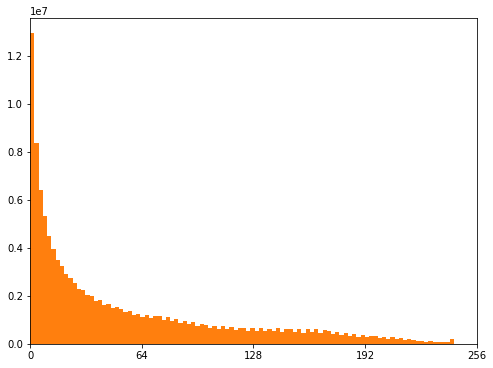

In [249]:
plt.figure(figsize=(8,6))
# plt.hist(im_mat.flatten(), 100);
counts, bins, bars = plt.hist(im_mat.flatten(), 100);

plt.xlim(0,255);
plt.xticks((np.linspace(0, 255+1, 5)));

# Recreate grating

## gauss convolve with sinusoid

In [18]:
# http://vision.psych.umn.edu/users/kersten/kersten-lab/courses/Psy5036W2017/Lectures/17_PythonForVision/Demos/html/2b.Gabor.html

def myimshow(I, **kwargs):
    im_ratio = I.shape[0] / I.shape[1]
    plt.imshow(I, cmap='gray', **kwargs)
    plt.colorbar(fraction=0.046*im_ratio, pad=0.04)
    # plt.axis('off')


def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    # Generate sinusoid stimuli
    # Sinusoid  I(x)=Acos(ωx+ρ) 
    # A  is the amplitude,  ρ  is the phase, and  ω  is the frequency.
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1]))
    stimuli = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return stimuli


def calc_freq_omega(freq_cycle_per_deg):
    # freq_cycle_per_deg: np array
    #   frequency of sinusoid grating in cycles per degree
    # return omega: np array
    #   frequency of sinusoid grating in radians per pixel
    freq_deg_per_cycle = 1.0 / freq_cycle_per_deg
    ncycle = visual_angle / freq_deg_per_cycle
    pix_per_cycle = stim_diameter / ncycle
    omega_x = 2*np.pi / pix_per_cycle # pixel per cycle = 2 * pi / omega
    return omega_x
assert math.isclose(calc_freq_omega(0.1), 0.03667228778509486, abs_tol = 0.001)

save_path = r'C:\Users\ll357\Documents\inter\results\interweaved vis stim - grating, nat img, noise'.replace('\\', '/')

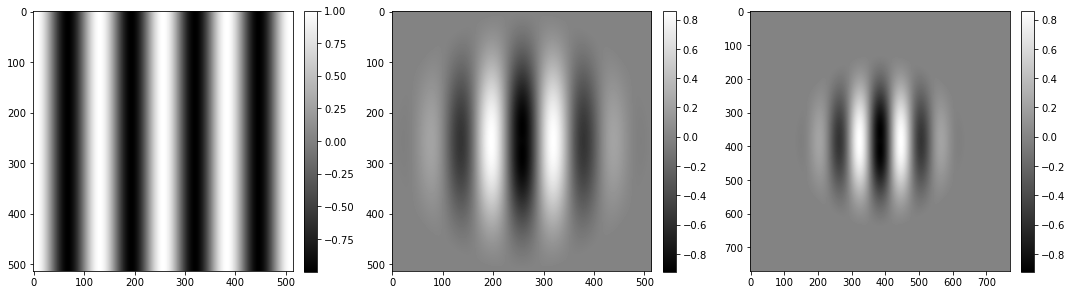

In [19]:
plt.figure(figsize=(15,6))

omega_x = 0.05
omega = [omega_x, 0.0]
rho = 0
sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
sin = genSinusoid(**sinusoidParam)
plt.subplot(1,3,1)
myimshow(sin)

conv = mask_0_base * sin * -1 # convolve sin with gauss then invert
plt.subplot(1,3,2)
myimshow(conv)

conv_pad = np.pad(conv, ((128,128),(128,128)), 'constant', constant_values=(0)) # add padding to g
plt.subplot(1,3,3)
myimshow(conv_pad)

plt.tight_layout()

## apply mask_0_base to sin as alpha channel

In [20]:
cpd_array = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd
# cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2) # below 0.03 cpd, static grating is not visible
# print(cpd_array)
# cpd_array = cpd_array[2:] # remove low freq
# cpd_array = cpd_array[:-2] # remove high freq
cpd_array

array([0.02, 0.04, 0.08, 0.16, 0.32, 0.64])

In [11]:
# cpd_str = ["{0:0.2f}".format(i) for i in cpd_array]
# omega_list = calc_freq_omega(cpd_array)
# os.chdir(save_path)

# for omega_x, cpd_x in zip(omega_list, cpd_str):
#     omega = [omega_x, 0.0]
#     rho = 0
#     sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
#     sin = genSinusoid(**sinusoidParam)

#     plt.imsave(fname=save_path + f"/grat_SF_{cpd_x}_no_mask.png", arr=sin, cmap='gray_r', format='png') 
#     # save img with specific pixel number: https://stackoverflow.com/a/63091765
#     # inverted grayscale "gray_r" takes care of the minus in (-1 * gauss * sinusoid)

#     # im_sin = Image.open('grat.png').convert('RGB')
#     # im_sin = np.array(im_sin)
#     # rgba = cv2.cvtColor(im_sin, cv2.COLOR_RGB2RGBA)

#     # mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 # convert mask from 0-1 to 0-255
#     # mask_0_base[mask_0_base<0] = 0 # force edge (outside of incircle) = 0
#     # mask_0_base = mask_0_base.astype(np.uint8)
#     # rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
#     # img_rgba = Image.fromarray(rgba)
#     # img_rgba.save(save_path + f"/grat_alpha_{cpd_x}.png")

#     # rgb = rgba[:, :, :-1] * rgba[:, :, [-1]] # multiply alpha channel. jpg only support RGB
#     # img_rgb = Image.fromarray(rgb)
#     # img_rgb.save(save_path + f"/grat_alpha_{cpd_x}.jpg") # this gives very cthulhu-like image
    
#     # display(img_rgba)

## Chris fix

In [22]:
# mworks developer Chris fixed the code for grating png construction
# https://mworks.discourse.group/t/issues-with-adding-a-gaussian-mask-to-a-png-image/867/5

'''
# The issue is not with the mask or how the alpha channel is rendered. The problem is the base grating.

# Your genSinusoid function generates a normal sinusoid ranging from -1 to 1. This is fine if you’re working in linear color (which is what MWorks does internally). However, you’re putting these values (after converting them to integers in the range [0,255]) in to a PNG file with no colorspace information. The standard way to interpret a PNG (or any other image) with no colorspace info is to assume that the colors are in the sRGB colorspce, which uses a nonlinear gamma.

# This means that when color management is enabled in MWorks (which it is by default), MWorks applies a sRGB-to-linear conversion of the PNG’s colors before rendering it. Since the image colors aren’t actually in sRGB, they end up looking quite different than you’d expect.

# The simplest way to solve this is to convert the computed grating values from linear gamma to sRGB gamma before storing them in the PNG. Here’s a modified version of your image generation code that does this:

# FYI, I found that the matplotlib function you were using to generate the mask-free image alters the colors in ways I don’t understand. I recommend using PIL to create both images, which is what my modified code does.

# If you think more detailed examples would be helpful, I can finish putting those together and send them along. But I’m pretty sure that switching to the above code will eliminate the discrepancy between your generated gratings and MWorks’ gratings.
'''

cpd_str = ["{0:0.2f}".format(i) for i in cpd_array]
omega_list = calc_freq_omega(cpd_array)

for omega_x, cpd_x in zip(omega_list, cpd_str):
    omega = [omega_x, 0.0]
    rho = 0
    sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
    sin = genSinusoid(**sinusoidParam)

    # Normalize range to [0, 1]
    sin = (sin + 1.0) / 2.0

    # Convert from linear color to sRGB
    sin = np.piecewise(sin,
                       [sin < 0.0031308],
                       [(lambda x: 12.92 * x),
                        (lambda x: 1.055 * np.power(x, 1.0/2.4) - 0.055)])

    # Convert from float64 [0, 1] to uint8 [0, 255]
    sin = np.round_(255.0 * sin).astype(np.uint8)

    no_mask_file_name = f"/grat_SF_{cpd_x}_no_mask.png"
    im_sin = Image.fromarray(sin, mode='L').convert('RGB')

    #
    # Include the PNG sRGB chunk in the output image.  While not strictly
    # necessary, this makes it clear that we really mean for the image colors
    # to be in the sRGB color space.
    # https://www.w3.org/TR/png/#srgb-standard-colour-space
    
    pnginfo = PngInfo()
    pnginfo.add(b'sRGB', b'\x00')
    im_sin.save(save_path + no_mask_file_name, pnginfo=pnginfo)

    rgba = np.array(im_sin.convert('RGBA'))
    mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 # convert mask from 0-1 to 0-255
    mask_0_base[mask_0_base<0] = 0 # force edge (outside of incircle) = 0
    mask_0_base = mask_0_base.astype(np.uint8)
    rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
    img_rgba = Image.fromarray(rgba)

    # Again, include the PNG sRGB chunk in the output image
    img_rgba.save(save_path + f"/grat_alpha_{cpd_x}.png", pnginfo=pnginfo)

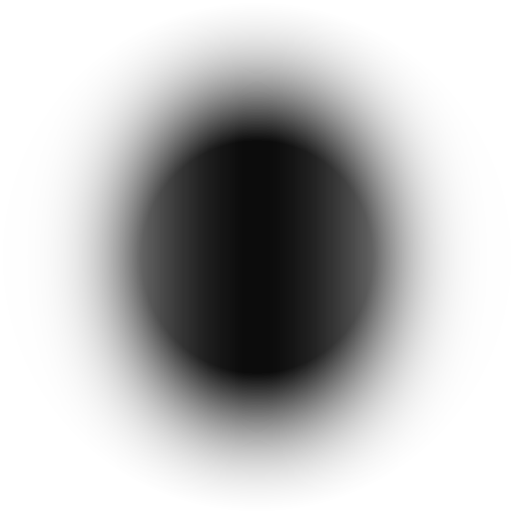

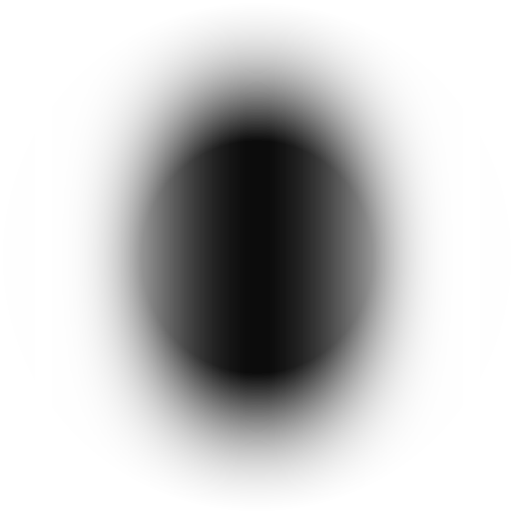

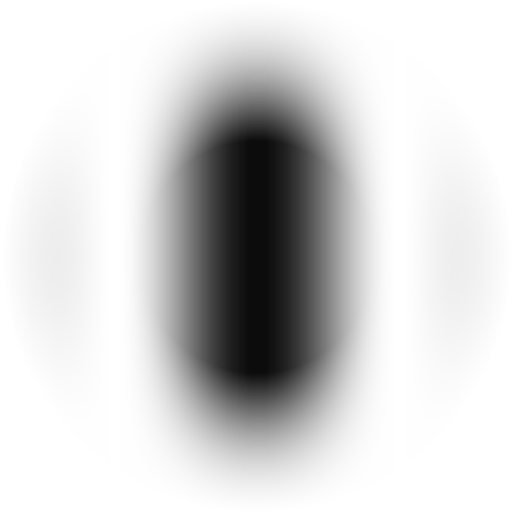

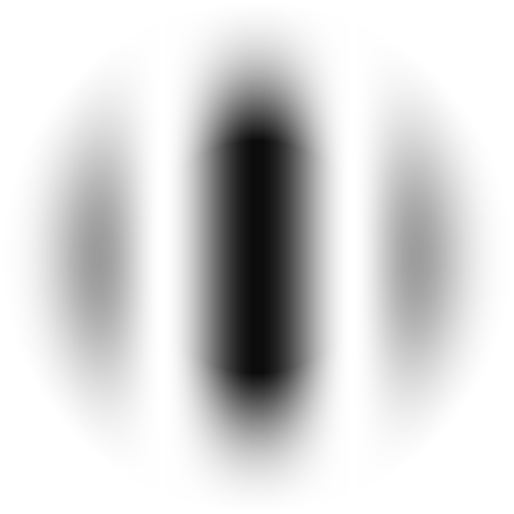

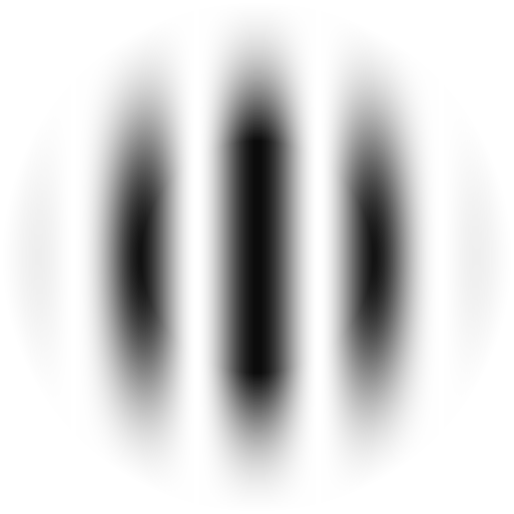

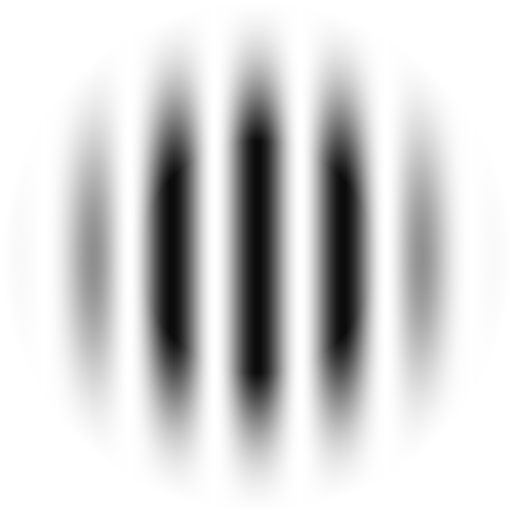

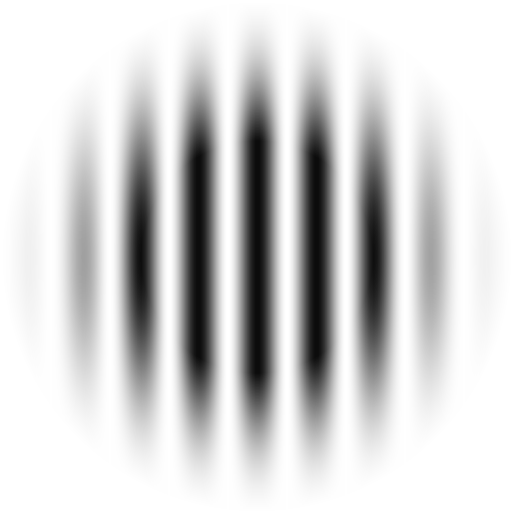

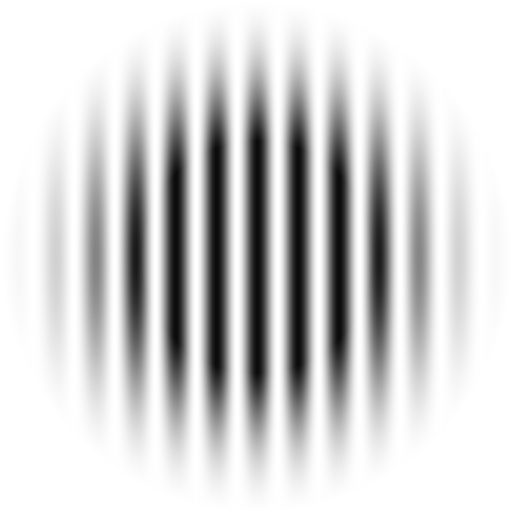

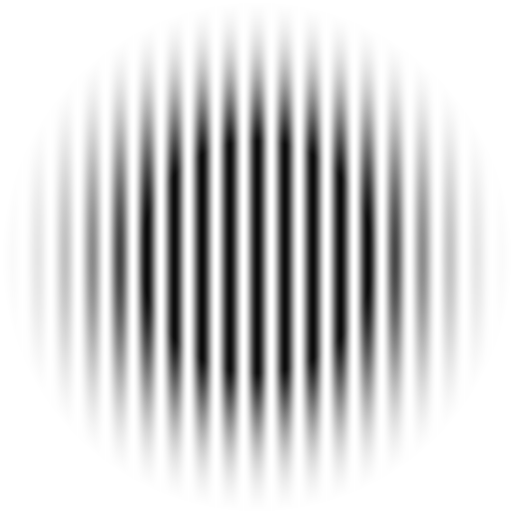

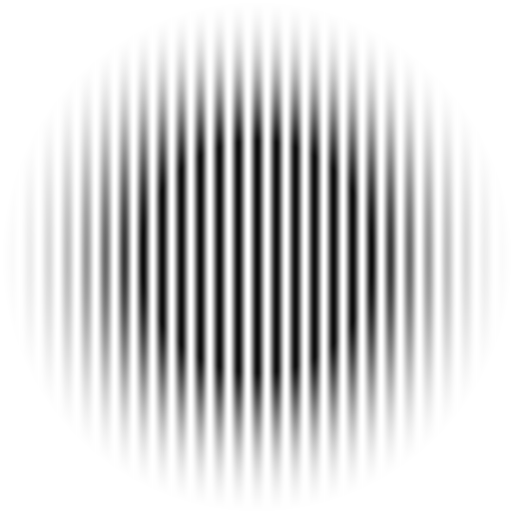

In [297]:
# # rename png for mwork

# cpd_str = ["{0:0.2f}".format(i) for i in cpd_array]
# omega_list = calc_freq_omega(cpd_array)
# os.chdir(save_path)

# for count, omega_x in enumerate(omega_list, start=31): # 31-40.png are gratings
# # for omega_x, cpd_x in zip(omega_list, cpd_str):
#     omega = [omega_x, 0.0]
#     rho = 0
#     sinusoidParam = {'A':1, 'omega':omega, 'rho':rho, 'sz':(stim_diameter, stim_diameter)}
#     sin = genSinusoid(**sinusoidParam)

#     plt.imsave(fname='grat.png', arr=sin, cmap='gray_r', format='png') 
#     # save img with specific pixel number: https://stackoverflow.com/a/63091765
#     # inverted grayscale "gray_r" takes care of the minus in (-1 * gauss * sinusoid)

#     im_sin = Image.open('grat.png').convert('RGB')
#     im_sin = np.array(im_sin)
#     rgba = cv2.cvtColor(im_sin, cv2.COLOR_RGB2RGBA)

#     mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 # convert mask from 0-1 to 0-255
#     mask_0_base[mask_0_base<0] = 0 # force edge (outside of incircle) = 0
#     mask_0_base = mask_0_base.astype(np.uint8)
#     rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
#     img = Image.fromarray(rgba)
#     img.save(save_path + f"/{count}.png")

#     display(img)

# coarse noise

In [298]:
def make_checkerboard_LL(
    shape,
    n_clusters,
    *,
    noise=0.0,
    minval=0,
    maxval=255,
    random_state=None,
):
    """Generate an array with block checkerboard structure for biclustering.
    Read more in the :ref:`User Guide <sample_generators>`.
    from https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/datasets/_samples_generator.py

    Parameters
    ----------
    shape : tuple of shape (n_rows, n_cols)
        The shape of the result.
    n_clusters : int or array-like or shape (n_row_clusters, n_column_clusters)
        The number of row and column clusters.
    noise : float, default=0.0
        The standard deviation of the gaussian noise.
    minval : int, default=10
        Minimum value of a bicluster.
    maxval : int, default=100
        Maximum value of a bicluster.
    shuffle : bool, default=True
        Shuffle the samples.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    X : ndarray of shape `shape`
        The generated array.
    rows : ndarray of shape (n_clusters, X.shape[0])
        The indicators for cluster membership of each row.
    cols : ndarray of shape (n_clusters, X.shape[1])
        The indicators for cluster membership of each column.
    See Also
    --------
    make_biclusters : Generate an array with constant block diagonal structure
        for biclustering.
    References
    ----------
    .. [1] Kluger, Y., Basri, R., Chang, J. T., & Gerstein, M. (2003).
        Spectral biclustering of microarray data: coclustering genes
        and conditions. Genome research, 13(4), 703-716.
    """
    from sklearn.utils.validation import check_random_state
    generator = check_random_state(random_state)

    if hasattr(n_clusters, "__len__"):
        n_row_clusters, n_col_clusters = n_clusters
    else:
        n_row_clusters = n_col_clusters = n_clusters

    n_rows, n_cols = shape
    row_sizes = n_rows // n_row_clusters * np.ones(n_row_clusters)
    col_sizes = n_cols // n_col_clusters * np.ones(n_col_clusters)

    row_labels = np.hstack(
        list(np.repeat(val, rep) for val, rep in zip(range(n_row_clusters), row_sizes))
    )
    col_labels = np.hstack(
        list(np.repeat(val, rep) for val, rep in zip(range(n_col_clusters), col_sizes))
    )

    result = np.zeros(shape, dtype=np.float64)
    for i in range(n_row_clusters):
        for j in range(n_col_clusters):
            selector = np.outer(row_labels == i, col_labels == j)
            result[selector] += generator.uniform(minval, maxval)

    if noise > 0:
        result += generator.normal(scale=noise, size=result.shape)

    rows = np.vstack(
        [
            row_labels == label
            for label in range(n_row_clusters)
            for _ in range(n_col_clusters)
        ]
    )
    cols = np.vstack(
        [
            col_labels == label
            for _ in range(n_row_clusters)
            for label in range(n_col_clusters)
        ]
    )

    return result, rows, cols

In [299]:
# find prime factors 
def prime_factors(n):
    i = 2
    factors = []
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.append(i)
    if n > 1:
        factors.append(n)
    return factors
prime_factors(510)

[2, 3, 5, 17]

In [ ]:
# TODO: automate edge cases: data shape cannot divide by n_clusters. pad, then gauss
# TODO: or better: pad the gauss with 0 to match data shape

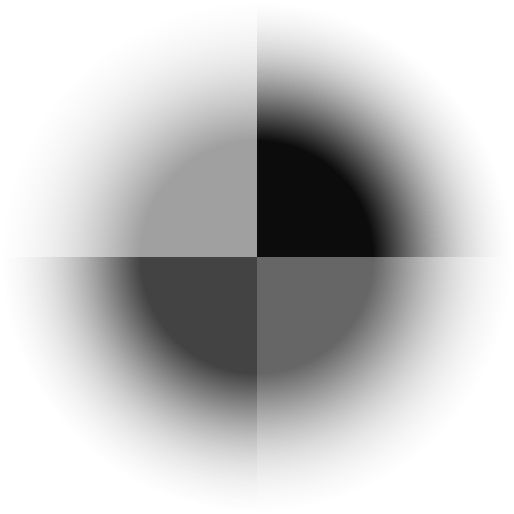

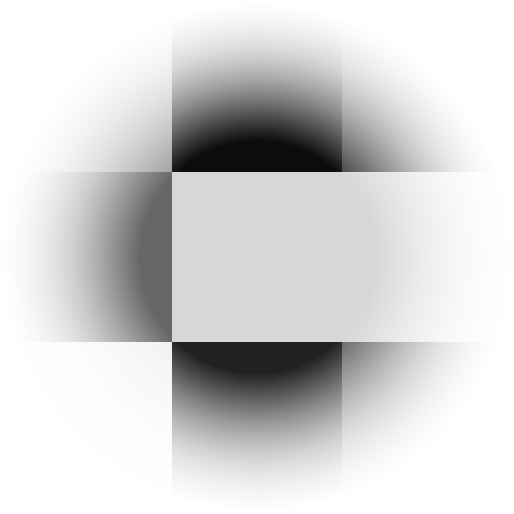

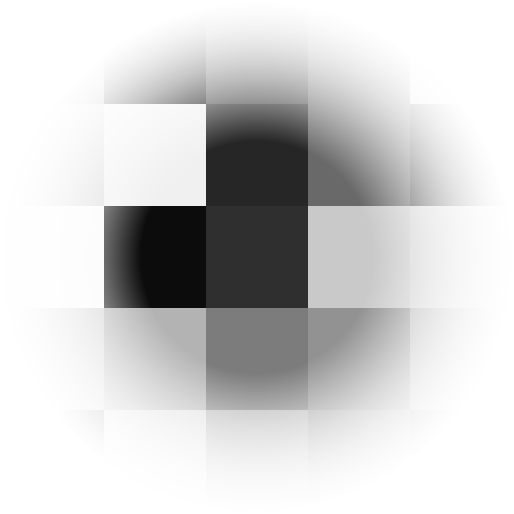

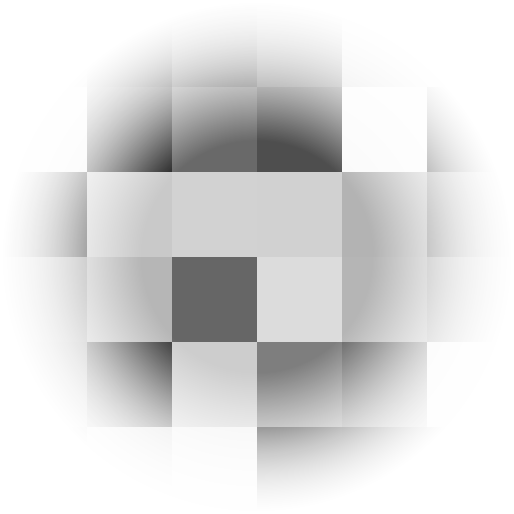

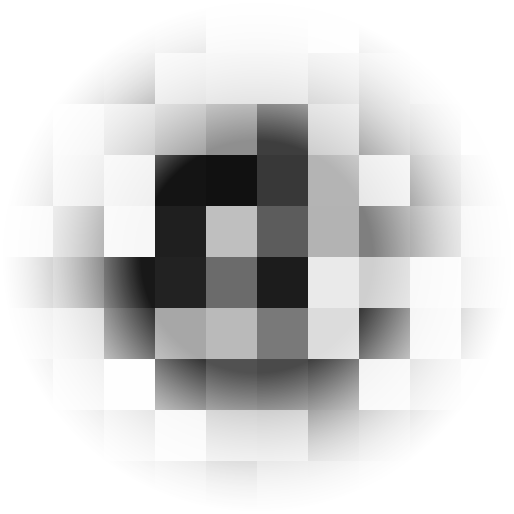

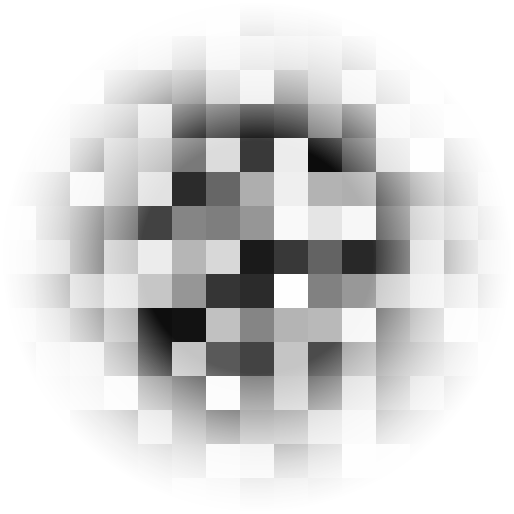

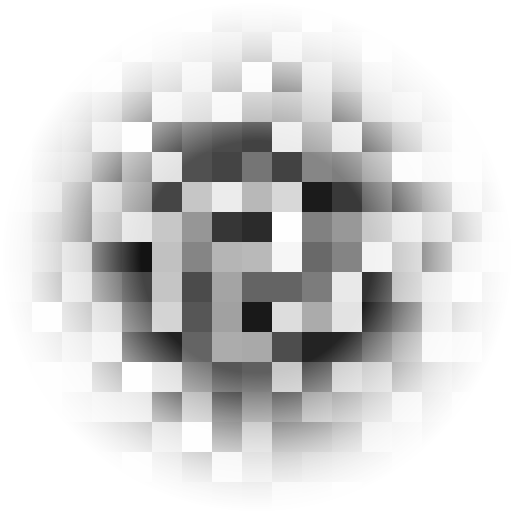

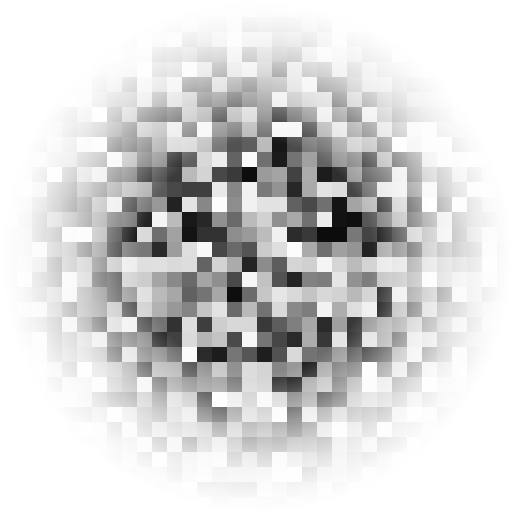

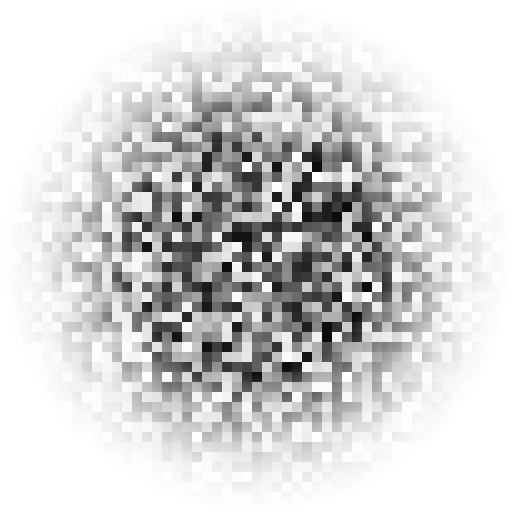

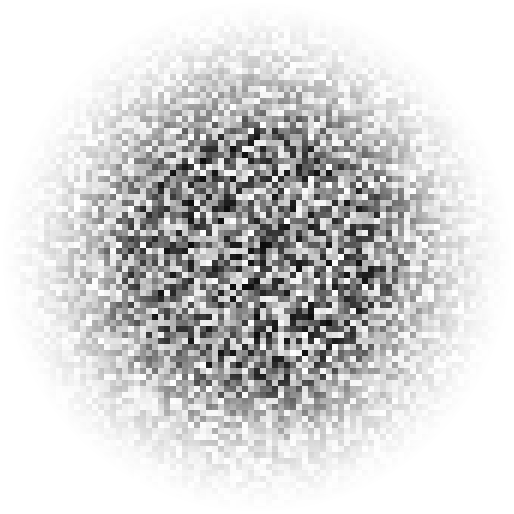

In [303]:
n_list = [2,3,5,17, 6,10,34, 15,51,85]
n_list = np.sort(n_list)

for count, n in enumerate(n_list, start=41): # 41-50.png are noises
# for n in n_list:
    n_clusters = (n, n)
    data, rows, columns = make_checkerboard_LL(
        shape=(510, 510), n_clusters=n_clusters, noise=0, random_state=42
    )
    data = np.pad(data, ((2,2),(2,2)), 'constant', constant_values=(0)) # pad data to match gauss
    # plt.matshow(data, cmap=plt.cm.gray)
    os.chdir(save_path)
    plt.imsave(fname='noise.png', arr=data, cmap='gray_r', format='png') 

    im_sin = Image.open('noise.png').convert('RGB')
    im_sin = np.array(im_sin)
    rgba = cv2.cvtColor(im_sin, cv2.COLOR_RGB2RGBA)

    mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 # convert mask from 0-1 to 0-255
    mask_0_base[mask_0_base<0] = 0 # force edge (outside of incircle) = 0
    mask_0_base = mask_0_base.astype(np.uint8)
    rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)
    img = Image.fromarray(rgba)
    img.save(save_path + f"/{count}.png")

    display(img)

# spatial freq domain

In [3]:
dir_img = r'Z:\All_Staff\home\lan\Mwork\mix50 - bunnytop high lum contrast mix grating and noise\Image'.replace('\\', '/')
os.chdir(dir_img)
dir_save_recon = r'C:\Users\ll357\Documents\inter\results\fourier_transform_reconstruct_img'.replace('\\', '/')

## fourier transform

In [4]:
# # https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

# # fourier_synthesis.py

# image_filename = "28.png"

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre) ** 2 + (coords[1] - centre) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]),
            centre + (centre - coords[1]))

def display_plots(individual_grating, reconstruction, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(individual_grating)
    ax1.axis('off')
    ax2.imshow(reconstruction)
    ax2.axis('off')
    fig.suptitle(f"Terms: {idx}")

    # fig.savefig(dir_save_recon + f"/fourier_recon_mix50_img28_{idx}.png")
    fig.show()
    plt.pause(0.01)
    # plt.close(fig)

# # Read and process image
# image = plt.imread(image_filename)
# image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

# # Array dimensions (array is square) and centre pixel
# # Use smallest of the dimensions and ensure it's odd
# array_size = min(image.shape) - 1 + min(image.shape) % 2

# # Crop image so it's a square image
# image = image[:array_size, :array_size]
# centre = int((array_size - 1) / 2)

# # Get all coordinate pairs in the left half of the array,
# # including the column at the centre of the array (which
# # includes the centre pixel)
# coords_left_half = (
#     (x, y) for x in range(array_size) for y in range(centre+1)
# )

# # Sort points based on distance from centre
# coords_left_half = sorted(
#     coords_left_half,
#     key=lambda x: calculate_distance_from_centre(x, centre)
# )

# plt.set_cmap("gray")

# ft = calculate_2dft(image)

# # Show grayscale image and its Fourier transform
# plt.subplot(121)
# plt.imshow(image)
# plt.axis("off")
# plt.subplot(122)
# plt.imshow(np.log(abs(ft)))
# plt.axis("off")
# plt.pause(2)

# # Reconstruct image
# fig = plt.figure()
# # Step 1
# # Set up empty arrays for final image and
# # individual gratings
# rec_image = np.zeros(image.shape)
# individual_grating = np.zeros(
#     image.shape, dtype="complex"
# )
# idx = 0

# # All steps are displayed until display_all_until value
# display_all_until = 50
# # After this, skip which steps to display using the
# # display_step value
# display_step = 100
# # Work out index of next step to display
# next_display = display_all_until + display_step

# # Step 2
# for coords in coords_left_half:
#     # Central column: only include if points in top half of
#     # the central column
#     if not (coords[1] == centre and coords[0] > centre):
#         idx += 1
#         symm_coords = find_symmetric_coordinates(
#             coords, centre
#         )
#         # Step 3
#         # Copy values from Fourier transform into
#         # individual_grating for the pair of points in
#         # current iteration
#         individual_grating[coords] = ft[coords]
#         individual_grating[symm_coords] = ft[symm_coords]

#         # Step 4
#         # Calculate inverse Fourier transform to give the
#         # reconstructed grating. Add this reconstructed
#         # grating to the reconstructed image
#         rec_grating = calculate_2dift(individual_grating)
#         rec_image += rec_grating

#         # Clear individual_grating array, ready for
#         # next iteration
#         individual_grating[coords] = 0
#         individual_grating[symm_coords] = 0

#         # Don't display every step
#         if idx < display_all_until or idx == next_display:
#             if idx > display_all_until:
#                 next_display += display_step
#                 # Accelerate animation the further the
#                 # iteration runs by increasing
#                 # display_step
#                 display_step += 10
#             display_plots(rec_grating, rec_image, idx)
            
#         clear_output(wait=True) # clear cell output

# plt.show()

img size: 557
len of coords_left_half: 155403


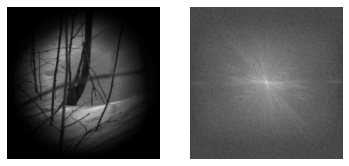

In [5]:
image_filename = "28.png" # example natural image
# image_filename = "36.png" # example grating # TODO: fix log(0)
image = plt.imread(image_filename)
image = image[:, :, :3].mean(axis=2) * image[:, :, -1]  # Convert to grayscal, then alpha

# Array dimensions (array is square) and centre pixel
# Use smallest of the dimensions and ensure it's odd
array_size = min(image.shape) - 1 + min(image.shape) % 2
print(f'img size: {array_size}')

# Crop image so it's a square image
image = image[:array_size, :array_size]
centre = int((array_size - 1) / 2)
plt.set_cmap("gray")
# plt.imshow(image);

# Get all coordinate pairs in the left half of the array,
# including the column at the centre of the array (which
# includes the centre pixel)
coords_left_half = (
    (x, y) for x in range(array_size) for y in range(centre+1)
) # this is a generator

# Sort points based on distance from centre
coords_left_half = sorted(
    coords_left_half,
    key=lambda x: calculate_distance_from_centre(x, centre)
) # sort by distance from centre, aka frequency
print(f'len of coords_left_half: {len(coords_left_half)}') # approx 557**2/2 

ft = calculate_2dft(image)

# Show grayscale image and its Fourier transform
plt.subplot(121)
plt.imshow(image)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off");

# from center to edge: freq increases
# rotating: orientation 
# value of point: amplitude
# phase: seen before abs

## low / high / band pass filter

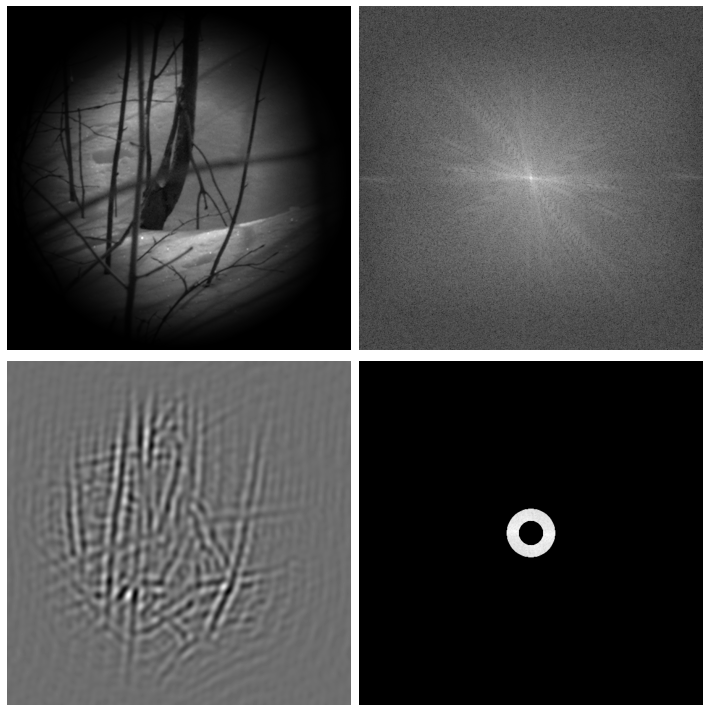

In [12]:
# calculate the distance from the center of each point
ft_distance = np.zeros(ft.shape)
for x in range(ft.shape[0]):
    for y in range(ft.shape[1]):
        ft_distance[x, y] = calculate_distance_from_centre((x, y), centre) 

# set points with certain distance to 0
ft_filtered = ft.copy()
distance_range = np.amax(ft_distance) - np.amin(ft_distance)

# ft_filtered[ft_distance > 0.02*distance_range] = 1e-8 # low pass filter, set to almost 0 to avoid log(0)
# ft_filtered[ft_distance < 0.1*distance_range] = 1e-8 # high pass filter
ft_filtered[ft_distance < 0.05*distance_range] = 1e-8
ft_filtered[ft_distance > 0.1*distance_range] = 1e-8 # band pass filter
# TODO: convert SF unit from pixel SF percentile to cycle/degree

# inverse fourier transform from ft_filtered
image_filtered = calculate_2dift(ft_filtered)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image);
plt.axis("off");

plt.subplot(222)
plt.imshow(np.log(abs(ft)))
plt.axis("off");

plt.subplot(223)
plt.imshow(image_filtered)
plt.axis("off");

plt.subplot(224)
plt.imshow(np.log(abs(ft_filtered)))
plt.axis("off");

plt.tight_layout()

dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
plt.savefig(os.path.join(dir_fig, 'fourier_transform_band_pass.pdf'), bbox_inches='tight')

## SF content distribution

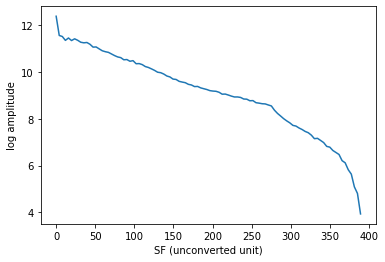

In [58]:
# plt.subplot(121)
# plt.imshow(ft_distance)
# plt.subplot(122)
# plt.imshow(np.log(abs(ft)))

# fourier domain is visualized as np.log(abs(ft)), while log addresses extreme values. abs is amplitude
# to sum over all ori and get 1 SF, take abs(ft) and sum over all ori
# final form: ft.abs.sum.log -> plot log amplitude against SF
distance_step = 0.01 * distance_range
SF_arr = np.arange(0, distance_range, distance_step)
SF_band_amp = np.zeros(SF_arr.shape)

for idx, distance_start in enumerate(np.arange(0, distance_range, distance_step)):
    ft_band = ft.copy()
    ft_band[ft_distance < distance_start] = 0
    ft_band[ft_distance > distance_start + distance_step] = 0
    SF_band_amp[idx] = np.sum(np.sum(abs(ft_band)))

SF_band_amp = np.log(SF_band_amp) # log amplitude of each SF band
plt.plot(SF_arr, SF_band_amp);
plt.xlabel('SF (unconverted unit)')
plt.ylabel('log amplitude');

## orientation filter

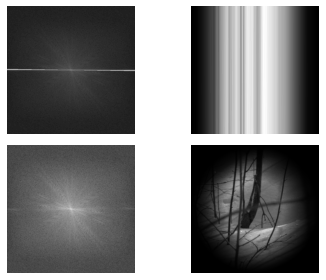

In [67]:
ori_filter = np.ones(ft.shape) * 1e-8
preserve_ori_deg = 90 # degree

def calculate_orientation_from_centre(coords, centre):
    x, y = coords
    x -= centre
    y -= centre
    if x == 0:
        ori = 90
    else:
        ori = np.arctan(y/x) * 180 / np.pi # degree
    return ori

# set points on the line of orientation to 1
centre = int((ft.shape[0] - 1) / 2)
for x in range(ft.shape[0]):
    for y in range(ft.shape[1]):
        ori = calculate_orientation_from_centre((x, y), centre)
        if abs(ori - preserve_ori_deg) < 1:
            ori_filter[x, y] = 1

ft_ori_filtered = ft * ori_filter

image_ori_filtered = calculate_2dift(ft_ori_filtered)

plt.subplot(221)
plt.imshow(np.log(abs(ft_ori_filtered)))
plt.axis("off");
plt.subplot(222)
plt.imshow(image_ori_filtered)
plt.axis("off");
plt.subplot(223)
plt.imshow(np.log(abs(ft)))
plt.axis("off");
plt.subplot(224)
plt.imshow(image);
plt.axis("off");
plt.tight_layout()

## reconstruct from fourier domain

In [ ]:
# Reconstruct image
fig = plt.figure()
# Step 1
# Set up empty arrays for final image and
# individual gratings
rec_image = np.zeros(image.shape)
individual_grating = np.zeros(
    image.shape, dtype="complex"
)
idx = 0

# All steps are displayed until display_all_until value
display_all_until = 50
# After this, skip which steps to display using the
# display_step value
display_step = 100
# Work out index of next step to display
next_display = display_all_until + display_step

# Step 2
for coords in coords_left_half[:10]:
    # Central column: only include if points in top half of
    # the central column
    if not (coords[1] == centre and coords[0] > centre):
        idx += 1
        symm_coords = find_symmetric_coordinates(
            coords, centre
        )
        # Step 3
        # Copy values from Fourier transform into
        # individual_grating for the pair of points in
        # current iteration
        individual_grating[coords] = ft[coords]
        individual_grating[symm_coords] = ft[symm_coords]

        # Step 4
        # Calculate inverse Fourier transform to give the
        # reconstructed grating. Add this reconstructed
        # grating to the reconstructed image
        rec_grating = calculate_2dift(individual_grating)
        rec_image += rec_grating

        # Clear individual_grating array, ready for
        # next iteration
        individual_grating[coords] = 0
        individual_grating[symm_coords] = 0

        # Don't display every step
        if idx < display_all_until or idx == next_display:
            if idx > display_all_until:
                next_display += display_step
                # Accelerate animation the further the
                # iteration runs by increasing
                # display_step
                display_step += 10
            display_plots(rec_grating, rec_image, idx)
            
        clear_output(wait=True) # clear cell output

plt.show()